# Data Mining: Association Rules
### Apriori Algorithm for Analyzing Shopping Baske

In response to the request from the marketing department of the company, which requires an analysis of purchases made by customers in order to obtain patterns of combinations of products purchased, for the creation of promotional packs and improvement of the store layout; we prepared an analysis of Association Rules using the ***Apriori algorithm***.

Association rule algorithms are a technique within data mining, aimed at finding patterns of relationships within a set of transactions.
The Apriori algorithm is designed to operate on databases containing transactions (for example, collections of items purchased by consumers) where each transaction is viewed as a set of items and is one of the most widely used to create recommendation systems that we see on many websites.

## Libraries

In [11]:
#pip install mysql-connector-python
import mysql.connector
import pandas.io.sql as psql
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
from IPython.display import HTML


## Make the coneccion

In [12]:
conexion = mysql.connector.connect(user='root', password ='12345',
                                    host='localhost',
                                    database='nuevo_esquema',
                                    port='3306')
print(conexion)

## We make the query

In [13]:
Q1 = '''
SELECT 
	t1.SalesOrderID AS  factura
    ,t1.ProductID AS stockId
    ,t2.Name AS producto
    ,t1.OrderQty AS cantidad
	,DATE_FORMAT(t3.OrderDate, "%y-%m-%d") AS fecha
    ,t1.LineTotal AS monto
    ,t3.CustomerID AS cliente
FROM nuevo_esquema.salesorderdetail AS t1
	JOIN nuevo_esquema.product AS t2 ON t1.ProductID = t2.ProductID
    JOIN nuevo_esquema.salesorderheader AS t3 ON t1.SalesOrderID = t3.SalesOrderID;;
'''
df = pd.read_sql_query(Q1, con=conexion)
conexion.close()

In [14]:
# We show the query
df.head(5)

,factura,stockId,producto,cantidad,fecha,monto,cliente
0,43659,776,"Mountain-100 Black, 42",1,01-06-30,2024.994,676
1,43659,777,"Mountain-100 Black, 44",3,01-06-30,6074.982,676
2,43659,778,"Mountain-100 Black, 48",1,01-06-30,2024.994,676
3,43659,771,"Mountain-100 Silver, 38",1,01-06-30,2039.994,676
4,43659,772,"Mountain-100 Silver, 42",1,01-06-30,2039.994,676


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121317 entries, 0 to 121316
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   factura   121317 non-null  int64  
 1   stockId   121317 non-null  int64  
 2   producto  121317 non-null  object 
 3   cantidad  121317 non-null  int64  
 4   fecha     121317 non-null  object 
 5   monto     121317 non-null  float64
 6   cliente   121317 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 6.5+ MB


In [16]:
df.shape

(121317, 7)

### Data preparation

In [17]:
# Removing white spaces in product name
df['producto'] = df['producto'].str.strip()

# Discarding rows without any invoice number
df.dropna(axis = 0, subset =['factura'], inplace = True)
df['factura'] = df['factura'].astype('str')

In [21]:
# We prepare the data by grouping by invoice and product
basket = (df
		.groupby(['factura', 'producto'])['cantidad']
		.sum().unstack().reset_index().fillna(0)
		.set_index('factura'))
basket.head(5)     

producto,AWC Logo Cap,All-Purpose Bike Stand,Bike Wash - Dissolver,Cable Lock,Chain,"Classic Vest, L","Classic Vest, M","Classic Vest, S",Fender Set - Mountain,Front Brakes,...,"Touring-3000 Yellow, 54","Touring-3000 Yellow, 58","Touring-3000 Yellow, 62",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
factura,,,,,,,,,,,,,,,,,,,,,
43659,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43661,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We perform one-hot encoding

One-hot encoding is a technique for encoding categorical variables that is used in the field of data mining and machine learning. The technique involves encoding a categorical variable with N categories into N binary variables (also known as "hot" variables), where each variable represents a single category. Each observation has a value of 1 in the variable associated with its category and a value of 0 in all other variables.

For example, imagine we have a categorical variable with 3 categories: red, green, and blue. We could encode this variable into 3 binary variables, each representing a category:

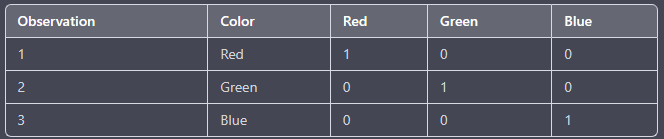

One-hot encoding is useful in the context of data mining and machine learning because many algorithms in these fields are unable to process categorical variables directly. By encoding the categorical variables into binary variables, we can use these algorithms to analyze and model the data.

In [22]:
# Definition of the hot encoding function to make the data suitable for the libraries
def hot_encode(x):
	if(x<= 0):
		return 0
	if(x>= 1):
		return 1

# Applying the function
basket_encoded = basket.applymap(hot_encode)
basket = basket_encoded
basket.head(5)

producto,AWC Logo Cap,All-Purpose Bike Stand,Bike Wash - Dissolver,Cable Lock,Chain,"Classic Vest, L","Classic Vest, M","Classic Vest, S",Fender Set - Mountain,Front Brakes,...,"Touring-3000 Yellow, 54","Touring-3000 Yellow, 58","Touring-3000 Yellow, 62",Water Bottle - 30 oz.,"Women's Mountain Shorts, L","Women's Mountain Shorts, M","Women's Mountain Shorts, S","Women's Tights, L","Women's Tights, M","Women's Tights, S"
factura,,,,,,,,,,,,,,,,,,,,,
43659,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43660,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43661,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43663,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Creation of the apriori model to obtain the Association Rules

In [23]:
# Create the model
frq_items = apriori(basket, min_support = 0.04, use_colnames = True)

# Gathering the inferred rules into a data frame
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

c:\Users\relat\.conda\envs\maestria\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


### Explorando las Reglas de Asociación Obtenidas

The following table shows the main Association Rules of products found and can be interpreted as follows:

* LHS: Product (or combination of products sold).
* RHS: Product that is likely to be sold from the previous one(s).
* Support: Support tells us how frequent an element or a set of elements (from the LHS column) is in all the data. Basically, it tells us how popular a set of elements is in the analyzed data set (decimal data representing percentage data).
* Confidence: Confidence tells us how likely the consequent is when the antecedent has occurred. Analogously to the previous rule, what is the probability of someone buying the product in the RHS column when they have already bought the one in the LHS column?
* Lift: Lift tells us how likely the consequent is when the antecedent has already occurred, taking into account the support of both antecedents and consequents; if it is <1 it is unlikely; if it is 1 it is not likely; if it is> 1 it is very likely.
* Count: Number of times it has occurred.